In [5]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = WindyGridworldEnv()

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [58]:
def sarsa_lambda(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, lda = 0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        
        # Initialize eligibility trace
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        curr_state = env.reset() # initialize state from the beginning

        curr_action_probs = policy(curr_state)
        curr_action = np.random.choice(np.arange(len(curr_action_probs)), p=curr_action_probs)
        
        num_steps = 0
        total_reward = 0
        
        while True:
            next_state, reward, done, info = env.step(curr_action)
            
            if done:
                ## print("Episode Terminated")
                break;
            
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            delta = reward + discount_factor*Q[next_state][next_action] - Q[curr_state][curr_action]
            E[curr_state][curr_action] = E[curr_state][curr_action] + 1
            for key, values in Q.items():
                for value in range(len(values)):
                    Q[key][value] += alpha*delta*E[key][value]
                    E[key][value] = discount_factor*lda*E[key][value]
            
            curr_state = next_state
            curr_action = next_action
            
            num_steps += 1
            total_reward += reward
            
        stats.episode_lengths[i_episode] = num_steps
        stats.episode_rewards[i_episode] = total_reward
        
    return Q, stats

In [53]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        curr_state = env.reset() # initialize state from the beginning
        curr_action_probs = policy(curr_state)
        curr_action = np.random.choice(np.arange(len(curr_action_probs)), p=curr_action_probs)
        num_steps = 0
        ep_rewards = 0
        
        while True:
            next_state, reward, done, info = env.step(curr_action)

            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            Q[curr_state][curr_action] = Q[curr_state][curr_action] + alpha * \
            (reward + discount_factor*Q[next_state][next_action] - Q[curr_state][curr_action])
            
            curr_state = next_state
            curr_action = next_action
            num_steps += 1
            ep_rewards += reward
            
            if done:
                #print("Episode Terminated")
                break
            
        stats.episode_lengths[i_episode] = num_steps
        stats.episode_rewards[i_episode] = ep_rewards
        
    return Q, stats

In [56]:
Q, stats = sarsa(env, 700)

Episode 700/700.

In [61]:
Q, stats = sarsa_lambda(env, 700)

Episode 700/700.

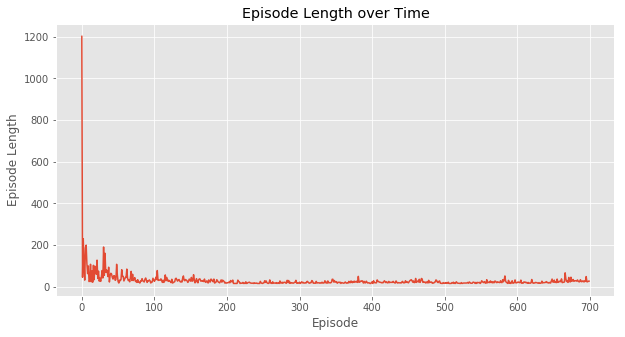

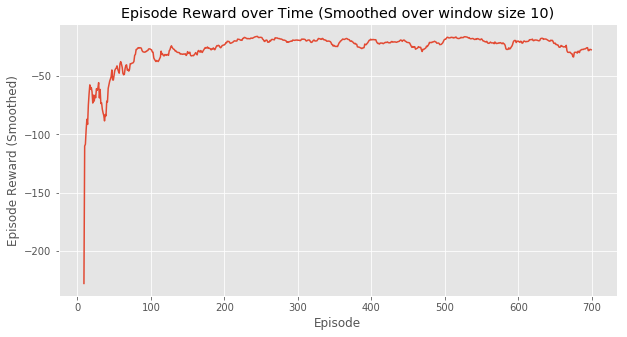

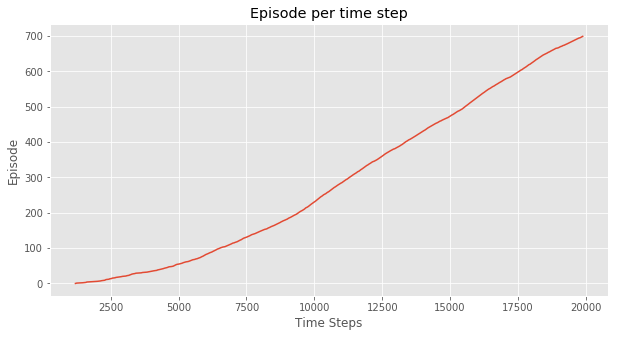

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [57]:
plotting.plot_episode_stats(stats)

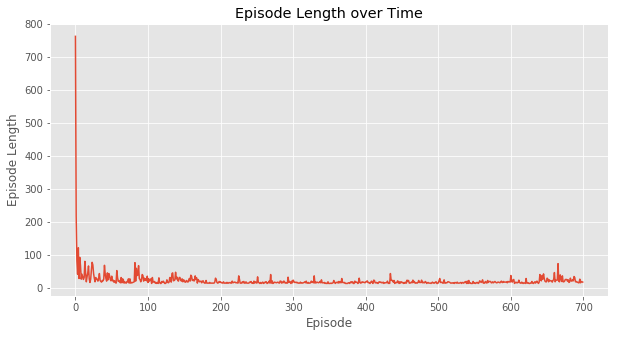

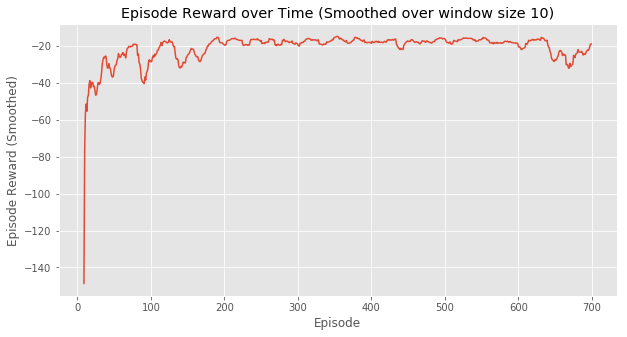

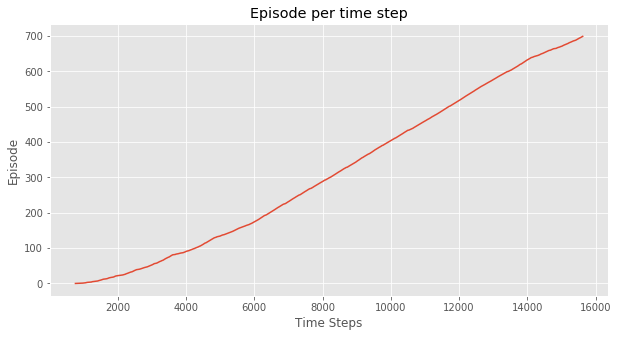

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [62]:
plotting.plot_episode_stats(stats)